# Face Generation using Pytorch Pre-trained Model

Pytorch Hub is a pre-trained model repository designed to facilitate research reproducibility. 

Using TorchNet in Analytics-Zoo, we can easily load these pre-trained model and make a distributed inference with only a few lines of code change.

Here is an easy example of loading Pytorch pretrained [Progressive Growing of GANs (PGAN)](https://pytorch.org/hub/facebookresearch_pytorch-gan-zoo_pgan/) from Pytorch Hub to Analytics-Zoo, and generate faces in distributed mode on Spark. We just make a little change of the pytorch prediction example code in sector 1.

## 1. Pytorch's example
This sector will show you how pytorch run the generation. The code in this sector is copied from [PGAN](https://pytorch.org/hub/facebookresearch_pytorch-gan-zoo_pgan/).  
The next sector will show you how to run a distributed generation using Analytics-Zoo and Spark.

### Load pretrained model from Pytorch Hub
Load [PGAN](https://pytorch.org/hub/facebookresearch_pytorch-gan-zoo_pgan/) from Pytorch Hub.
This PGAN model trained on high-quality celebrity faces "celebA" dataset, and will output 512 x 512 pixel images

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

In [3]:
import torch

model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=False)

Using cache found in /home/xin/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


### Generate noise with model's build-in method

In [4]:
num_images = 64
noise, _ = model.buildNoiseData(num_images)

### Run Generation in Pytorch

In [5]:
with torch.no_grad():
    generated_images = model.test(noise)

### Show Image with Matplotlib and Torchvision

In [6]:
import torchvision
grid = torchvision.utils.make_grid(torch.Tensor(generated_images).clamp(min=-1, max=1), scale_each=True, normalize=True)

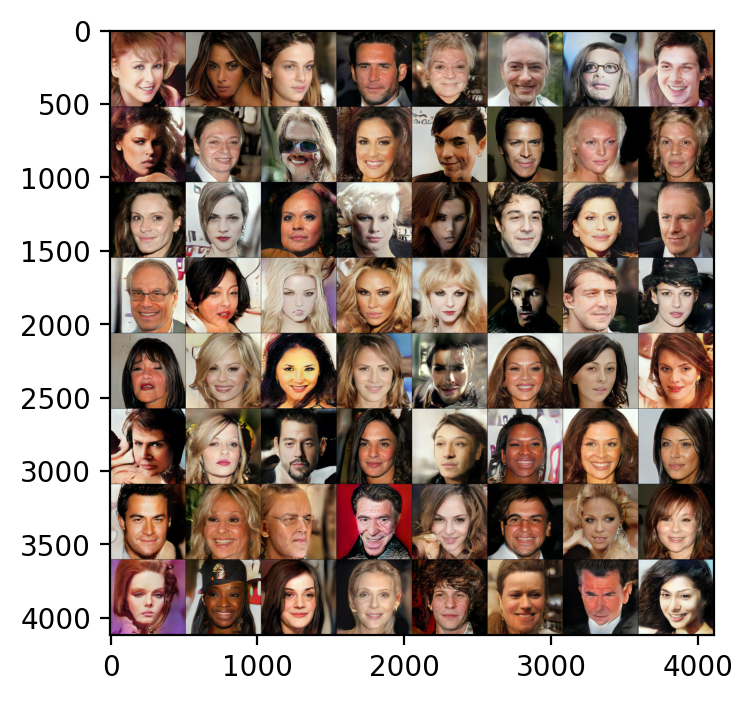

In [7]:
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

## 2. Run Distributed Generation on Spark using TorchNet
This sector will show you how to load a pretrained pytorch model to Analytics-Zoo, and run generation in distributed mode.

### Initialize Analytics-Zoo

In [8]:
from bigdl.orca.common import init_orca_context
from bigdl.orca.torch import TorchModel
import numpy as np
import os
hadoop_conf_dir = os.environ.get('HADOOP_CONF_DIR')
                                 
if 'sc' in dir():
    sc = init_orca_context(cluster_mode="spark-submit")
else:
    sc = init_orca_context(cores = 4, conf = {"spark.driver.memory": "10g"})

Prepending /opt/anaconda3/envs/nzoo/lib/python3.7/site-packages/bigdl/share/dllib/conf/spark-bigdl.conf to sys.path
Initializing orca context
Current pyspark location is : /opt/anaconda3/envs/nzoo/lib/python3.7/site-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /opt/anaconda3/envs/nzoo/lib/python3.7/site-packages/bigdl/share/dllib/lib/bigdl-dllib-0.14.0-SNAPSHOT-jar-with-dependencies.jar:/opt/anaconda3/envs/nzoo/lib/python3.7/site-packages/bigdl/share/orca/lib/bigdl-orca-0.14.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
2021-10-14 15:19:05 WARN  Utils:66 - Your hostname, xin-dev resolves to a loopback address: 127.0.0.1; using 10.239.158.56 instead (on interface enp0s31f6)
2021-10-14 15:19:05 WARN  Utils:66 - Set SPARK_LOCAL_IP if you need to bind to another address
2021-10-14 15:19:05 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.Sample
BigDLBasePickler registering: bigdl.dllib.utils.common  Sample
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.EvaluatedResult
BigDLBasePickler registering: bigdl.dllib.utils.common  EvaluatedResult
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.JTensor
BigDLBasePickler registering: bigdl.dllib.utils.common  JTensor
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.JActivity
BigDLBasePickler registering: bigdl.dllib.utils.common  JActivity
Successfully got a SparkContext



User settings:

   KMP_AFFINITY=granularity=fine,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   OMP_NUM_THREADS=1

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=144
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_HAND_THREAD=false
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_FORKJOIN_FRAMES=true
   KMP_FORKJOIN_FRAMES_MODE=3
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_ITT_PREPARE_DELAY=0
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
 

### Construct noise RDD
Parallelize noise samples to spark RDD.

In [9]:
from bigdl.dllib.utils.common import Sample
noiseSamples = np.vsplit(noise.numpy(), num_images)
noiseRdd = sc.parallelize(noiseSamples).map(lambda n: Sample.from_ndarray(n.reshape(512), np.zeros(1)))

### Load Generation Network to TorchNet

In [10]:
from bigdl.orca.torch import TorchModel
def get_netG():
    model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=False)
    return model.netG
    

net = TorchModel.from_pytorch(get_netG)

Using cache found in /home/xin/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


### Run Generation in Distributed Mode
Just set distributed to true, the prediction will run on Spark.
The parameter batch_per_thread means how many noise data will be processed once in a thread. The total thread number is your total spark cores.

In [11]:
dist_result = net.predict(noiseRdd, batch_size=16)
dist_generated_images = dist_result.collect()

[Stage 0:>                                                          (0 + 4) / 4]Adding /opt/anaconda3/envs/nzoo/lib/python3.7/site-packages/bigdl/share/dllib/lib/bigdl-dllib-0.14.0-SNAPSHOT-jar-with-dependencies.jar:/opt/anaconda3/envs/nzoo/lib/python3.7/site-packages/bigdl/share/orca/lib/bigdl-orca-0.14.0-SNAPSHOT-jar-with-dependencies.jar to BIGDL_JARS
Prepending /opt/anaconda3/envs/nzoo/lib/python3.7/site-packages/bigdl/share/dllib/conf/spark-bigdl.conf to sys.path
Adding /opt/anaconda3/envs/nzoo/lib/python3.7/site-packages/bigdl/share/dllib/lib/bigdl-dllib-0.14.0-SNAPSHOT-jar-with-dependencies.jar:/opt/anaconda3/envs/nzoo/lib/python3.7/site-packages/bigdl/share/orca/lib/bigdl-orca-0.14.0-SNAPSHOT-jar-with-dependencies.jar to BIGDL_JARSAdding /opt/anaconda3/envs/nzoo/lib/python3.7/site-packages/bigdl/share/dllib/lib/bigdl-dllib-0.14.0-SNAPSHOT-jar-with-dependencies.jar:/opt/anaconda3/envs/nzoo/lib/python3.7/site-packages/bigdl/share/orca/lib/bigdl-orca-0.14.0-SNAPSHOT-jar-with-depen

### Show Image with Matplotlib and Torchvision
As __dist_generated_images__ is a list of ndarray, we need to concate them into a single ndarray.

In [12]:
dist_generated_images = np.stack(dist_generated_images)
dist_grid = torchvision.utils.make_grid(torch.Tensor(dist_generated_images).clamp(min=-1, max=1),
                                        scale_each=True, normalize=True)

The generated images are the same but our of order with pytorch's generation, due to the repartition(better performance) when we construct noise RDD. If you remove the repartition, this result will be exactly the same.

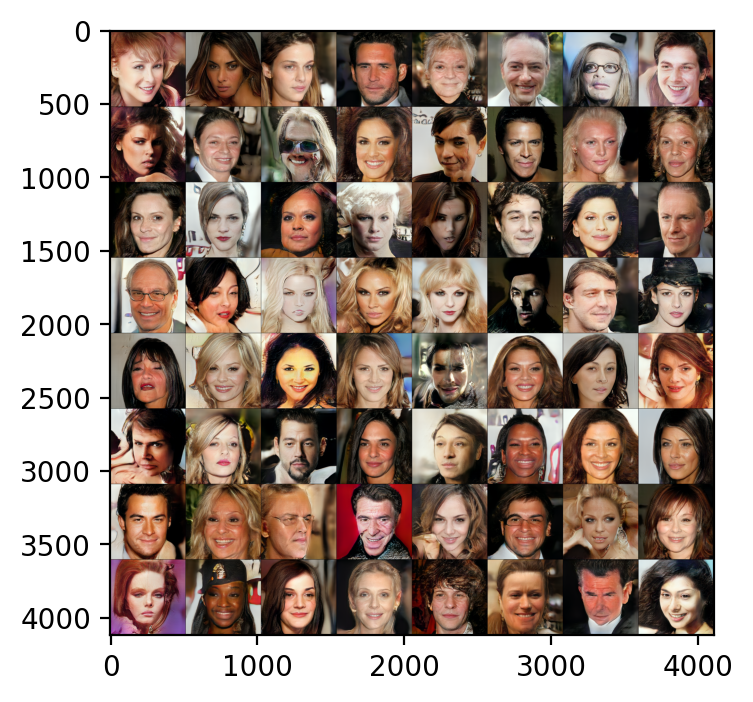

In [13]:
plt.imshow(dist_grid.permute(1, 2, 0).cpu().numpy())
plt.show()